# Depth Prediction Analysis

In this notebook we will briefly analyze the predicted depth data based on whether an object is contained in the foreground or background

In [1]:
import os
import time

import numpy as np
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from dataloader import CityScapesDataset
from transformations import *

In [4]:
from dataloader import CityScapesDataset


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

root = "C:/Users/itber/Documents/datasets/cityscapes"

test_transform = transforms.Compose([
    ToTensor(),
    Normalize()
])

valid_dataset = CityScapesDataset(root, transform=test_transform, split='val', label_map='trainId')
test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')

NUM_SEG_CLASSES = len(valid_dataset.trainid_2_name)

In [3]:
from labels import labels

def convert_to_numpy(image):
    if not isinstance(image, np.ndarray):
        if len(image.shape) == 2:
            image = image.detach().cpu().numpy()
        else:
            image = image.detach().cpu().numpy().transpose(1, 2, 0)

    return image

def get_color_mask(mask, labels, id_type='id'):
    try:
        h, w = mask.shape
    except ValueError:
        mask = mask.squeeze(-1)
        h, w = mask.shape

    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    if id_type == 'id':
        for lbl in labels:
            color_mask[mask == lbl.id] = lbl.color
    elif id_type == 'trainId':
        for lbl in labels:
            if (lbl.trainId != 255) | (lbl.trainId != -1):
                color_mask[mask == lbl.trainId] = lbl.color

    return color_mask


def plot_items(left, mask, depth, labels=None, num_seg_labels=34, id_type='id'):
    left = convert_to_numpy(left)
    mask = convert_to_numpy(mask)
    depth = convert_to_numpy(depth)

    # unnormalize left image
    left = (left*np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    # cmaps: 'prism', 'terrain', 'turbo', 'gist_rainbow_r', 'nipy_spectral_r'
    
    
    _, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(left)
    ax[0].set_title("Left Image")

    if labels:
        color_mask = get_color_mask(mask, labels, id_type)
        ax[1].imshow(color_mask)
    else:
        cmap = mpl.colormaps.get_cmap('nipy_spectral_r').resampled(num_seg_labels)
        ax[1].imshow(mask, cmap=cmap)

    ax[1].set_title("Seg Mask")
    ax[2].imshow(depth, cmap='plasma')
    ax[2].set_title("Depth")

### Load model

In [6]:
from torchvision.models import mobilenet_v3_small
from model import MobileNetV3Backbone, LightWeightRefineNet, MultiTaskNetwork


mobilenet_backbone = mobilenet_v3_small(weights='IMAGENET1K_V1')

encoder = MobileNetV3Backbone(mobilenet_backbone.features)
decoder = LightWeightRefineNet(NUM_SEG_CLASSES)
model = MultiTaskNetwork(encoder, decoder).to(DEVICE)

In [7]:
weights_path = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_24_ft_full.pth" # full res model

model.load_state_dict(torch.load(weights_path))
model.eval();

### Get Sample Prediction

In [81]:
sample = valid_dataset[123]
left, mask, depth = sample['left'], sample['mask'], sample['depth']
left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)

with torch.no_grad():
    # get predictions
    pred_seg, pred_depth = model(left.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


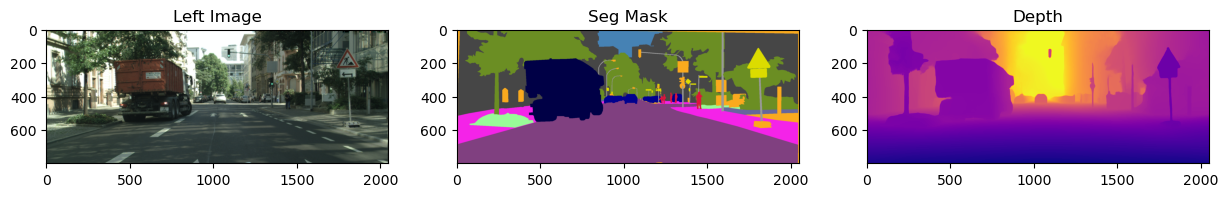

In [82]:
plot_items(left, mask, depth.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


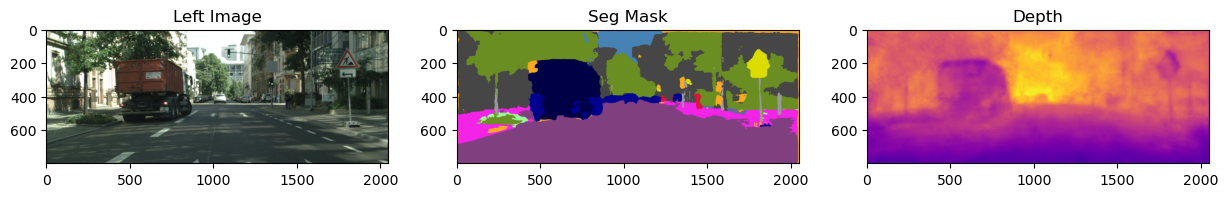

In [83]:
plot_items(left, pred_seg.argmax(dim=1).squeeze(0), pred_depth.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

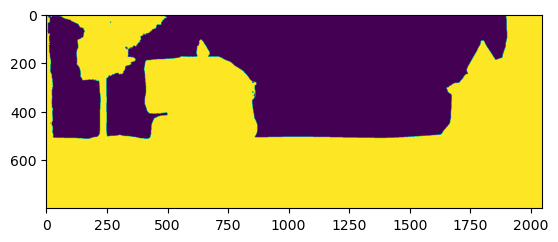

In [84]:
plt.imshow(np.exp(depth.cpu().numpy().squeeze()*5) < 25)

In [85]:
((mask != 19) & (mask > 10)).cpu().numpy()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [86]:
def select_depth(depth, mask):
    if not isinstance(mask, np.ndarray):
        mask = mask.cpu().numpy()
    if not isinstance(depth, np.ndarray):
        depth = depth.cpu().numpy()

    new_mask = (mask != 0) \
               & (mask != 1) \
               & (mask != 2) \
               & (mask != 3) \
               & (mask != 9) \
               & (mask != 10) \
               & (mask != 19) 
    
    new_depth = depth*new_mask
    new_depth[new_depth == 0] = np.nan
    return new_depth

In [88]:
np.sum(select_depth(depth, mask) > 0)

618962

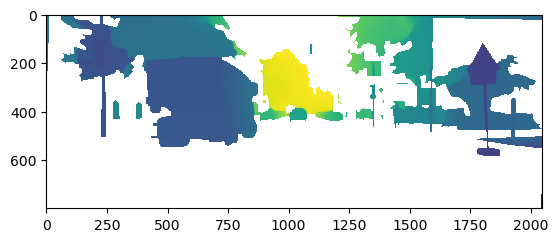

In [89]:
plt.imshow(select_depth(depth, mask).squeeze())

In [65]:
np.sum(select_depth(depth, mask).squeeze() < 10)

618962

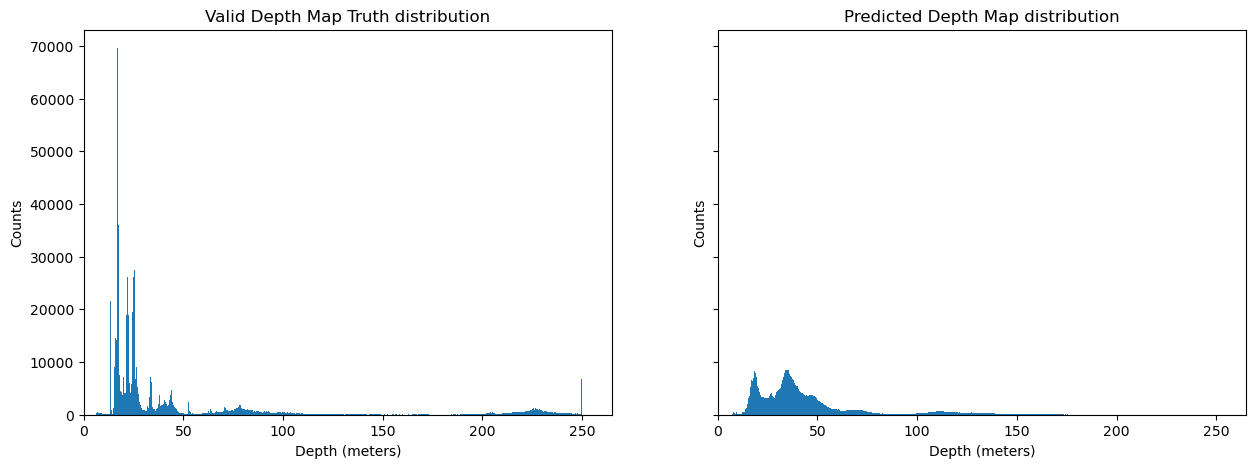

In [68]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].hist(np.exp(select_depth(depth, mask).flatten()*5), bins=500);
ax[0].set_title("Valid Depth Map Truth distribution");
ax[0].set_xlabel('Depth (meters)');
ax[0].set_ylabel('Counts');
ax[0].set_xlim(0, 265);

ax[1].hist(np.exp(select_depth(pred_depth, mask).flatten()*5), bins=500);
ax[1].set_title("Predicted Depth Map distribution");
ax[1].set_xlabel('Depth (meters)');
ax[1].set_ylabel('Counts');
ax[1].set_xlim(0, 265);

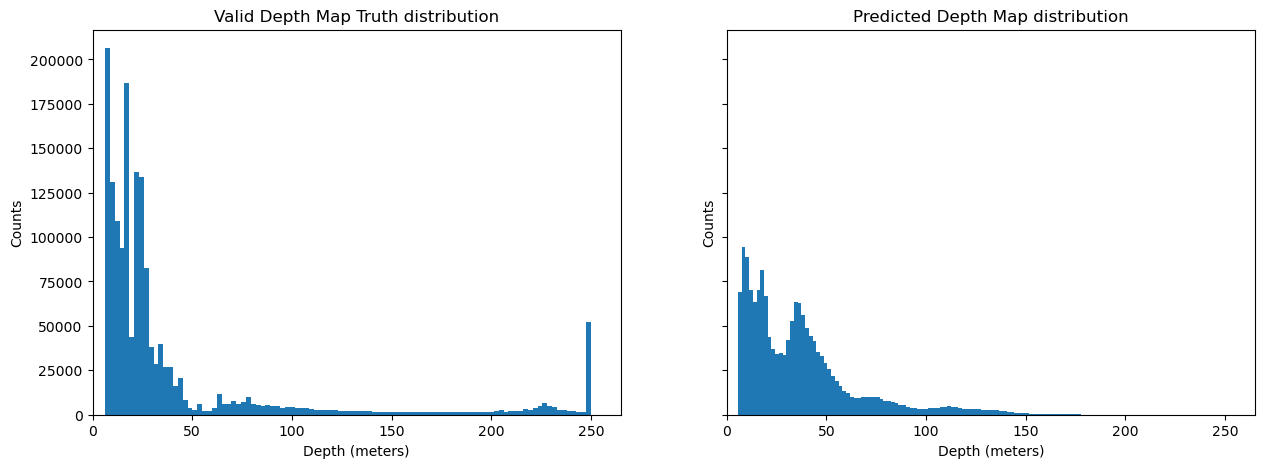

In [32]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].hist(np.exp(depth.cpu().numpy().flatten()*5), bins=100);
ax[0].set_title("Valid Depth Map Truth distribution");
ax[0].set_xlabel('Depth (meters)');
ax[0].set_ylabel('Counts');
ax[0].set_xlim(0, 265);

ax[1].hist(np.exp(pred_depth.cpu().numpy().flatten()*5), bins=100);
ax[1].set_title("Predicted Depth Map distribution");
ax[1].set_xlabel('Depth (meters)');
ax[1].set_ylabel('Counts');
ax[1].set_xlim(0, 265);

### Get true and predicted depth distributions

In [110]:
idxs = np.random.choice(len(valid_dataset), size=(100,), replace=False)


# pred_segs = []
depths = []
pred_depths = []
filtered_depths = []
filtered_pred_depths = []
with torch.no_grad():
    for i in idxs:
        sample = valid_dataset[i]
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)
        pred_seg, pred_depth = model(left.unsqueeze(0))

        # pred_segs.append(pred_seg.cpu().numpy())
        depths.append(depth.cpu().numpy())
        pred_depths.append(pred_depth.squeeze(0).cpu().numpy())

        filtered_depths.append(select_depth(depth, mask))
        filtered_pred_depths.append(select_depth(pred_depth.squeeze(0), mask)) 


depths = np.vstack(depths)
pred_depths = np.vstack(pred_depths)

filtered_depths = np.vstack(filtered_depths)
filtered_pred_depths = np.vstack(filtered_pred_depths)

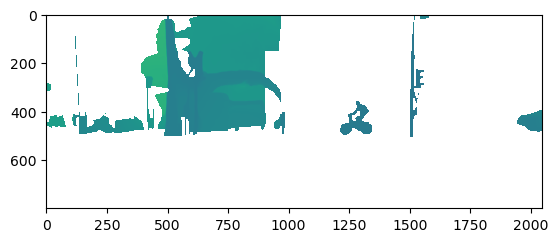

In [111]:
plt.imshow(select_depth(depth, mask).squeeze())

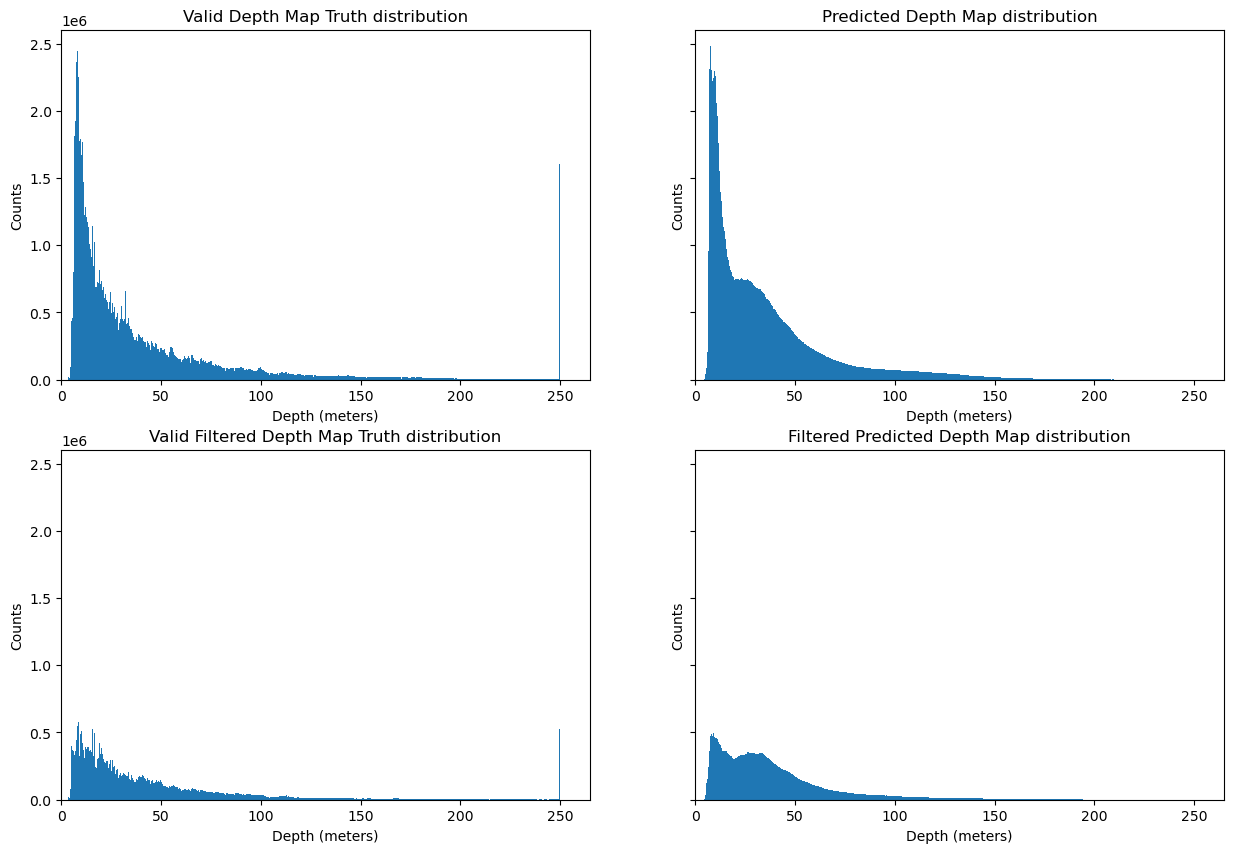

In [112]:
_, ax = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
ax[0, 0].hist(np.exp(depths.flatten()*5), bins=1000);
ax[0, 0].set_title("Valid Depth Map Truth distribution");
ax[0, 0].set_xlabel('Depth (meters)');
ax[0, 0].set_ylabel('Counts');
ax[0, 0].set_xlim(0, 265);

ax[0, 1].hist(np.exp(pred_depths.flatten()*5), bins=1000);
ax[0, 1].set_title("Predicted Depth Map distribution");
ax[0, 1].set_xlabel('Depth (meters)');
ax[0, 1].set_ylabel('Counts');
ax[0, 1].set_xlim(0, 265);


ax[1, 0].hist(np.exp(filtered_depths.flatten()*5), bins=1000);
ax[1, 0].set_title("Valid Filtered Depth Map Truth distribution");
ax[1, 0].set_xlabel('Depth (meters)');
ax[1, 0].set_ylabel('Counts');
ax[1, 0].set_xlim(0, 265);

ax[1, 1].hist(np.exp(filtered_pred_depths.flatten()*5), bins=1000);
ax[1, 1].set_title("Filtered Predicted Depth Map distribution");
ax[1, 1].set_xlabel('Depth (meters)');
ax[1, 1].set_ylabel('Counts');
ax[1, 1].set_xlim(0, 265);

Try to display things in 2D

Counts per bin VS median pixel value per row

In [127]:
# depth_2d = np.exp(depths*5).transpose(1, 0, 2).reshape((800, -1)).transpose(1, 0)
# pred_depth_2d = np.exp(pred_depths*5).transpose(1, 0, 2).reshape((800, -1)).transpose(1, 0)

depth_2d = depths.transpose(1, 0, 2).reshape((800, -1)).transpose(1, 0)
pred_depth_2d = pred_depths.transpose(1, 0, 2).reshape((800, -1)).transpose(1, 0)

In [131]:
# depth_cnts, depth_bins = np.histogram(np.exp(depths.flatten()*5).reshape((-1, 1)), bins=800)
# pred_depth_cnts, pred_depth_bins = np.histogram(np.exp(pred_depths.flatten()*5).reshape((-1, 1)), bins=800)

depth_cnts, depth_bins = np.histogram(depths.flatten().reshape((-1, 1)), bins=800)
pred_depth_cnts, pred_depth_bins = np.histogram(pred_depths.flatten().reshape((-1, 1)), bins=800)

<BarContainer object of 800 artists>

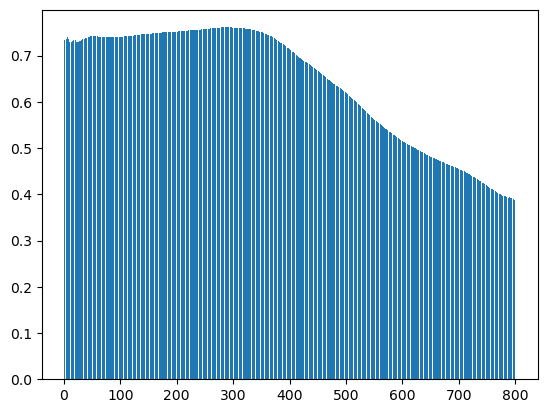

In [132]:
plt.bar(np.arange(1, 801), np.median(pred_depth_2d, axis=0))

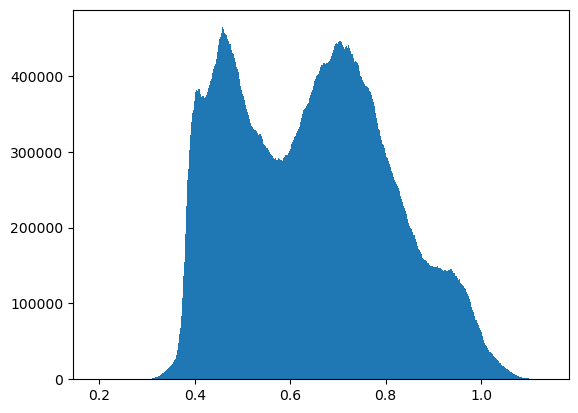

In [141]:
plt.hist(pred_depths.flatten().reshape((-1, 1)), bins=800);